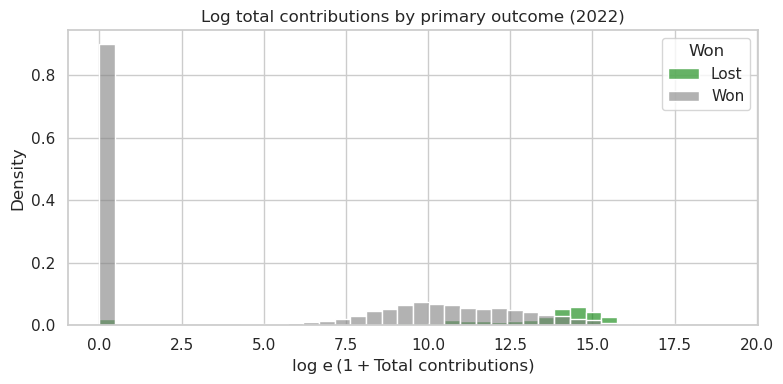

In [6]:
# ===============================================================
# EDA 1.  Fund‑raising (log dollars) by win status
# ===============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

fin_eda = pd.read_csv("candidate_summary_2022.csv")

house = pd.read_csv("house_elec.csv", encoding="latin1")
sen   = pd.read_csv("senate_elec.csv")

house = house[(house["PARTY"].isin(["R","D"])) & (house["PE WINNER INDICATOR"] == "W")]
sen   = sen[(sen["PARTY"].isin(["R","D"])) & (sen["PE WINNER INDICATOR"] == "W")]

winner_ids = pd.concat([house["FEC ID"], sen["FEC ID"]])
fin_eda["won"] = fin_eda["Cand_Id"].isin(winner_ids).astype(int)

# log‑transform total contributions
fin_eda["log_total_contrib"] = np.log1p(fin_eda["Total_Contribution"])

plt.figure(figsize=(8, 4))
sns.histplot(
    data=fin_eda, x="log_total_contrib", hue="won",
    bins=40, stat="density", palette={0: "gray", 1: "green"}, alpha=0.6
)
plt.title("Log total contributions by primary outcome (2022)")
plt.xlabel("log e (1 + Total contributions)")
plt.ylabel("Density")
plt.legend(title="Won", labels=["Lost", "Won"])
plt.tight_layout()
plt.show()

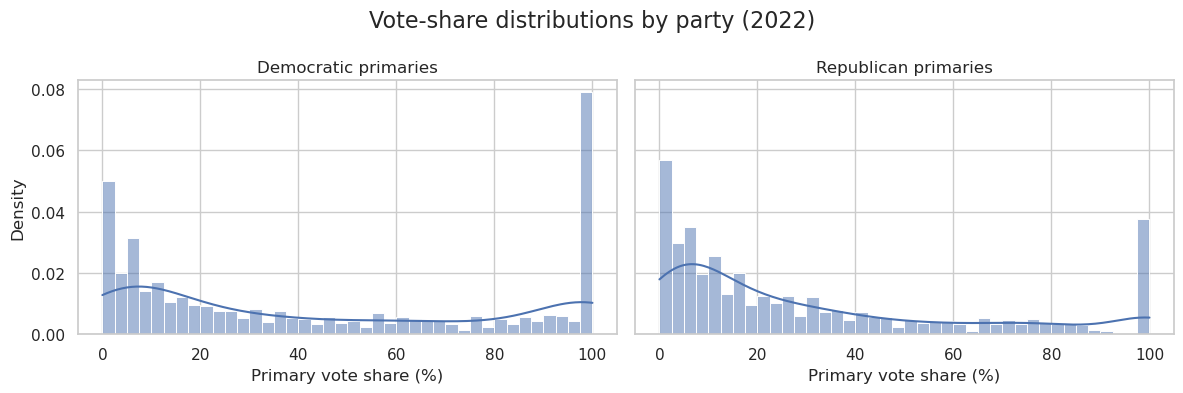

In [7]:
# ===============================================================
# EDA 2.  Vote‑share distribution by party
# ===============================================================
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

dem_eda = pd.read_csv("dem_candidates.csv").assign(party="DEM")
rep_eda = pd.read_csv("rep_candidates.csv").assign(party="REP")
cands_eda = pd.concat([dem_eda, rep_eda])

# vote share as percent
cands_eda = cands_eda.dropna(subset=["Primary %"])
cands_eda["vote_share"] = pd.to_numeric(
    cands_eda["Primary %"].astype(str).str.rstrip('%'), errors="coerce"
) / 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, party, title in zip(
        axes, ["DEM", "REP"], ["Democratic primaries", "Republican primaries"]):
    sns.histplot(
        cands_eda.loc[cands_eda.party == party, "vote_share"] * 100,
        bins=40, kde=True, stat="density", ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Primary vote share (%)")
    ax.grid(True)
axes[0].set_ylabel("Density")
plt.suptitle("Vote‑share distributions by party (2022)", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# ===============================================================
# 0  Imports
# ===============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import warnings; warnings.filterwarnings("ignore")

SEED = 42

# ===============================================================
# 1  Load raw CSVs
# ===============================================================
financial = pd.read_csv("candidate_summary_2022.csv")
sen       = pd.read_csv("senate_elec.csv")
hou       = pd.read_csv("house_elec.csv", encoding="latin1")

# keep DEM / REP only
financial = financial[financial["Cand_Party_Affiliation"].isin(["DEM","REP"])]

# ===============================================================
# 2  Build the binary outcome `won`
# ===============================================================
hou = hou.fillna(0)
hou = hou[(hou["PARTY"].isin(["R","D"])) & (hou["PE WINNER INDICATOR"] == "W")]

sen = sen.fillna(0)
sen = sen[(sen["PARTY"].isin(["R","D"])) & (sen["PE WINNER INDICATOR"] == "W")]

primary_winners = np.concatenate([sen["FEC ID"], hou["FEC ID"]])
financial["won"] = financial["Cand_Id"].isin(primary_winners).astype(int)

# ===============================================================
# 3  Feature engineering
# ===============================================================
race_totals = (
    financial.groupby(["Cand_Office_St","Cand_Office_Dist","Cand_Party_Affiliation"])
             ["Total_Contribution"]
             .sum()
             .reset_index()
             .rename(columns={"Total_Contribution":"Per_Race$"})
)
financial = financial.merge(
    race_totals,
    how="left",
    on=["Cand_Office_St","Cand_Office_Dist","Cand_Party_Affiliation"]
)

data = {
    "log_Funds_Raised": np.log1p(financial["Total_Contribution"]),
    "Raise_percentage": financial["Total_Contribution"] / financial["Per_Race$"],
    "Democrat"       : (financial["Cand_Party_Affiliation"] == "DEM").astype(int),
    "Senate"         : (financial["Cand_Office"] == "S").astype(int),
    "Incumbency"     : (financial["Cand_Incumbent_Challenger_Open_Seat"] == "INCUMBENT").astype(int),
    "log_Indiv_Contrib": np.log1p(financial["Individual_Contribution"]),
    "log_Party_Contrib": np.log1p(financial["Party_Committee_Contribution"]),
    "won"            : financial["won"]
}
df = pd.DataFrame(data).dropna()

X = df.drop(columns="won")
y = df["won"]

# ===============================================================
# 4  Train / test split
# ===============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED)

# numeric vs already‑binary columns
num_cols = ["log_Funds_Raised","Raise_percentage",
            "log_Indiv_Contrib","log_Party_Contrib"]
bin_cols = ["Democrat","Senate","Incumbency"]

preproc_glm = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("bin", "passthrough", bin_cols)
])

# ===============================================================
# 5  Logistic regression pipeline
# ===============================================================
glm_pipe = Pipeline([
    ("prep", preproc_glm),
    ("clf",  LogisticRegression(max_iter=1000, random_state=SEED))
])

glm_pipe.fit(X_train, y_train)

y_hat  = glm_pipe.predict(X_test)
y_prob = glm_pipe.predict_proba(X_test)[:,1]

print("=== Logistic Regression (test set) ===")
print(classification_report(y_test, y_hat, digits=3))
print("ROC‑AUC:", roc_auc_score(y_test, y_prob).round(3))

# ===============================================================
# 6  Coefficient table (odds ratios)
# ===============================================================
coef = glm_pipe.named_steps["clf"].coef_[0]
feature_names = preproc_glm.get_feature_names_out()
summary = pd.DataFrame({
    "feature": feature_names,
    "coef"   : coef,
    "odds_ratio": np.exp(coef)
}).sort_values("odds_ratio", ascending=False)

print("\nTop coefficients:")
print(summary.head(10).to_string(index=False))


=== Logistic Regression (test set) ===
              precision    recall  f1-score   support

           0      0.950     0.927     0.938       550
           1      0.756     0.821     0.787       151

    accuracy                          0.904       701
   macro avg      0.853     0.874     0.863       701
weighted avg      0.908     0.904     0.906       701

ROC‑AUC: 0.93

Top coefficients:
               feature      coef  odds_ratio
 num__Raise_percentage  1.587334    4.890691
num__log_Indiv_Contrib  0.495122    1.640698
num__log_Party_Contrib  0.311247    1.365127
       bin__Incumbency  0.268536    1.308048
 num__log_Funds_Raised  0.191064    1.210537
         bin__Democrat  0.000681    1.000681
           bin__Senate -0.433014    0.648551


In [9]:
# ===============================================================
# 0.  Imports
# ===============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings; warnings.filterwarnings("ignore")

SEED = 101

# ===============================================================
# 1.  Load raw CSVs
# ===============================================================
dem = pd.read_csv("dem_candidates.csv").assign(party="DEM")
rep = pd.read_csv("rep_candidates.csv").assign(party="REP")
cands = pd.concat([dem, rep], ignore_index=True)

# ===============================================================
# 2.  Clean outcome column (won / lost)
# ===============================================================
cands = cands.dropna(subset=["Primary %", "Primary Outcome"])
cands["Primary %"] = cands["Primary %"].astype(str).str.rstrip('%').astype(float)
cands["won"] = (cands["Primary Outcome"] == "Won").astype(int)

# ===============================================================
# 3.  Count national‑level endorsements
# ===============================================================
dem_cols = ["EMILY's List","Justice Dems","Indivisible","PCCC",
            "Our Revolution","Sunrise","Sanders","AOC","Party Committee"]
rep_cols = ["Trump","Club for Growth","Party Committee","Renew America",
            "E-PAC","VIEW PAC","Maggie's List","Winning for Women"]

def count_yes(frame, cols):
    return (frame[cols]
            .apply(lambda r: r.astype(str).str.startswith("Yes"))
            .sum(axis=1))

cands.loc[cands.party=="DEM", "endorse_cnt"] = count_yes(cands[cands.party=="DEM"], dem_cols)
cands.loc[cands.party=="REP", "endorse_cnt"] = count_yes(cands[cands.party=="REP"], rep_cols)

# ===============================================================
# 4.  Feature set and target
# ===============================================================
numeric_cols     = ["endorse_cnt"]
categorical_cols = ["Incumbent", "Office", "party"]

df_model = cands.dropna(subset=numeric_cols + categorical_cols + ["won"])
X = df_model[numeric_cols + categorical_cols]
y = df_model["won"]

# ===============================================================
# 5.  Train / test split
# ===============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED)

# ===============================================================
# 6.  Pre‑processing + Random Forest pipeline
# ===============================================================
preproc = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

rf_pipe = Pipeline([
    ("prep", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=2,
        random_state=SEED,
        n_jobs=-1))
])

# ===============================================================
# 7.  Fit model and evaluate
# ===============================================================
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest (test set) ===")
print(classification_report(y_test, y_pred, digits=3))
print("ROC‑AUC:", roc_auc_score(y_test, y_prob).round(3))

# ===============================================================
# 8.  Permutation feature importance
# ===============================================================
perm = permutation_importance(
    rf_pipe, X_test, y_test,
    n_repeats=30, random_state=SEED, n_jobs=-1
)

importance = (pd.Series(perm.importances_mean, index=X_test.columns)
                .sort_values(ascending=False))

print("\nTop 10 important features:")
print(importance.head(10))


=== Random Forest (test set) ===
              precision    recall  f1-score   support

           0      0.795     0.954     0.867       524
           1      0.860     0.534     0.659       277

    accuracy                          0.809       801
   macro avg      0.828     0.744     0.763       801
weighted avg      0.818     0.809     0.795       801

ROC‑AUC: 0.801

Top 10 important features:
Incumbent      0.141948
endorse_cnt    0.068414
party          0.000166
Office        -0.000042
dtype: float64
